### First implementaiton 
code source [url](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter05/Facial_keypoints_detection.ipynb)

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import pandas as pd
import cv2
from skimage import io, transform

cudnn.benchmark = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Getting the data

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv("P1_Facial_Keypoints/data/training_frames_keypoints.csv")

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 1 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (5805/5805), done.


In [3]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [4]:
def prep_landmarks(index=5):
  image_name = data.iloc[index, 0]
  landmarks = data.iloc[index, 1:]
  landmarks = np.asarray(landmarks)
  landmarks = landmarks.astype("float")
  landmarks = landmarks.reshape(-1, 2)

  print("Image name: {}".format(image_name))
  print("Landmarks shape: {}".format(landmarks.shape))
  print("First 4 Landmarks: {}".format(landmarks[:4]))
  return image_name, landmarks

_, _ = prep_landmarks()

Image name: Albert_Brooks_12.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 67. 134.]
 [ 69. 144.]
 [ 72. 154.]
 [ 77. 165.]]


Image name: Paul_Otellini_01.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[31. 74.]
 [31. 81.]
 [33. 89.]
 [34. 97.]]


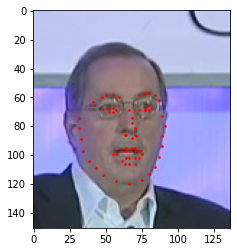

In [5]:
def show_landmarks(image, landmarks):
  """Show image with landmarks"""
  plt.imshow(image)
  plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
  plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
image_name, landmarks = prep_landmarks(10)
show_landmarks(io.imread(os.path.join(root_dir, image_name)), landmarks)

In [6]:
class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    
  def __len__(self): return len(self.df)
  def __getitem__(self, ix):  
    img_path = root_dir + self.df.iloc[ix, 0]
    # scaling the imge
    img = cv2.imread(img_path) / 255.
    # scaling the x,y coordinates 
    kp = copy.deepcopy(self.df.iloc[ix, 1:].tolist())
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img, kp2

  def preprocess_input(self, img):
    img = cv2.resize(img, (224, 224))
    img = torch.tensor(img).permute(2, 0, 1)
    img = self.normalize(img).float()
    return img.to(device)

  def load_img(self, ix):
    img_path = root_dir + self.df.iloc[ix, 0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    img = cv2.resize(img, (224, 224))
    return img

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
data.sort_values('Unnamed: 0')

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
2126,Abdel_Aziz_Al-Hakim_00.jpg,65.0,109.0,69.0,131.0,73.0,149.0,82.0,162.0,96.0,...,180.0,155.0,193.0,155.0,180.0,164.0,171.0,164.0,162.0,163.0
2006,Abdel_Aziz_Al-Hakim_01.jpg,74.0,103.0,78.0,125.0,83.0,143.0,91.0,157.0,100.0,...,184.0,149.0,197.0,149.0,184.0,154.0,175.0,158.0,166.0,158.0
1416,Abdel_Aziz_Al-Hakim_02.jpg,79.0,94.0,83.0,112.0,88.0,134.0,97.0,148.0,106.0,...,185.0,140.0,198.0,141.0,190.0,149.0,181.0,149.0,172.0,149.0
3324,Abdel_Aziz_Al-Hakim_10.jpg,65.0,111.0,68.0,123.0,71.0,132.0,74.0,142.0,80.0,...,105.0,139.0,120.0,136.0,105.0,139.0,102.0,142.0,95.0,142.0
2703,Abdel_Aziz_Al-Hakim_11.jpg,89.0,95.0,86.0,107.0,86.0,116.0,86.0,128.0,86.0,...,119.0,129.0,128.0,132.0,116.0,132.0,113.0,132.0,110.0,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Zhong_Nanshan_11.jpg,76.0,168.0,84.0,186.0,89.0,199.0,98.0,213.0,106.0,...,173.0,209.0,186.0,210.0,177.0,218.0,168.0,223.0,160.0,222.0
2331,Zhong_Nanshan_12.jpg,82.0,172.0,91.0,190.0,99.0,204.0,104.0,217.0,117.0,...,193.0,205.0,201.0,205.0,197.0,209.0,193.0,214.0,184.0,214.0
1316,Zhong_Nanshan_50.jpg,67.0,169.0,76.0,191.0,85.0,204.0,89.0,222.0,98.0,...,181.0,219.0,195.0,219.0,186.0,228.0,177.0,228.0,168.0,232.0
1843,Zhong_Nanshan_51.jpg,76.0,173.0,80.0,191.0,89.0,209.0,93.0,222.0,102.0,...,186.0,228.0,199.0,228.0,186.0,237.0,181.0,241.0,173.0,241.0


In [9]:
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, 3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )

  model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
  )

  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  return model.to(device), criterion, optimizer

In [10]:
model, criterion, optimizer = get_model()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [11]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [12]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" epoch {epoch+ 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item() 
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item() 
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 50
 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50
 epoch 21 : 50
 epoch 22 : 50
 epoch 23 : 50
 epoch 24 : 50
 epoch 25 : 50
 epoch 26 : 50
 epoch 27 : 50
 epoch 28 : 50
 epoch 29 : 50
 epoch 30 : 50
 epoch 31 : 50
 epoch 32 : 50
 epoch 33 : 50
 epoch 34 : 50
 epoch 35 : 50
 epoch 36 : 50
 epoch 37 : 50
 epoch 38 : 50
 epoch 39 : 50
 epoch 40 : 50
 epoch 41 : 50
 epoch 42 : 50
 epoch 43 : 50
 epoch 44 : 50
 epoch 45 : 50
 epoch 46 : 50
 epoch 47 : 50
 epoch 48 : 50
 epoch 49 : 50
 epoch 50 : 50


In [12]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

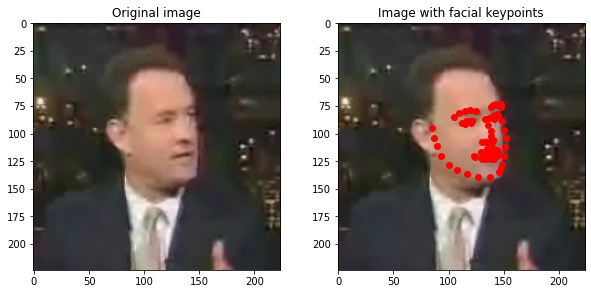

In [14]:
ix = 1
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()